<hr style="border:5px solid purple"> </hr>

# UW PCE DS 420 - Lesson 9:
# Deep Neural Networks and Applications (And CNNs)


<hr style="border:5px solid purple"> </hr>


In this lab we will be focusing on deep neural networks, CNNs, and thier applications.  We will primarily use the Tensorflow/Keras sequential layer API to do so. Make sure that you can run `import tensorflow as tf` without any errors.

<hr style="border:3px solid purple"> </hr>

## Auto Encoding/Compression w/ MNIST digits.

<hr style="border:3px solid purple"> </hr>

For this example we will use `tensorflow` with the MNIST dataset. The MNIST dataset is database of handwritten digits. The associated number to each image is provided in the dataset.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__
# Mine is `2.3.1` Anything over 2.0.0 should work.

'2.3.1'

Now that we imported TensorFlow library and Keras, we can start using them. Keras contains a version of the MNIST dataset which we will use in this lab. The next cell will read the MNIST dataset.

In [3]:
data = tf.keras.datasets.mnist

After loading the data, we will split it into training and testing.

In [4]:
(x_train, y_train), (x_test, y_test) = data.load_data()

11493376/11490434 [==============================] - 2s 0us/step


The training data consists of 60000 images of $28 \times 28$ pixels.

In [7]:
print("Training data dimensions: {}".format(x_train.shape))
print("Test data dimensions: {}".format(x_test.shape))

Training data dimensions: (60000, 28, 28)
Test data dimensions: (10000, 28, 28)


Let's look at a small section of the first example in the training data. This is the numeric representation of the top-left corner of the first image. Because we only have a single **channel**, the image is a grey-scale image.

In [8]:
x_train[0, 0:10, 0:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156]], dtype=uint8)

Let's check the label of the first image

In [9]:
y_train[0]

5

We will now plot the images to see what we are working with.

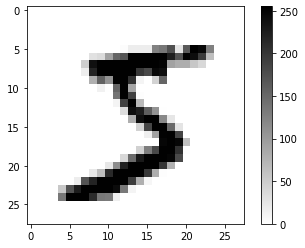

In [10]:
plt.figure()
plt.imshow(x_train[0, :, :], cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We notice each pixel can take values between 0 and 255. Neural networks work better when we normalize our data. To do that in our case, we can just divide each pixel value by 255, so that we end of with values between 0 and 1. This is similar to doing min-max normalization.

In [11]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We then check if our scaling worked.

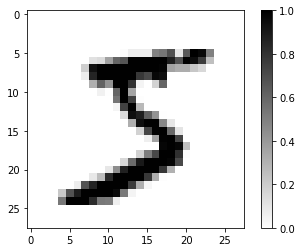

In [12]:
plt.figure()
plt.imshow(x_train[0], cmap = plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Before we build our deep learning model, let us explore what the data looks like. For that, we will plot our training images with their associated classes or digit.

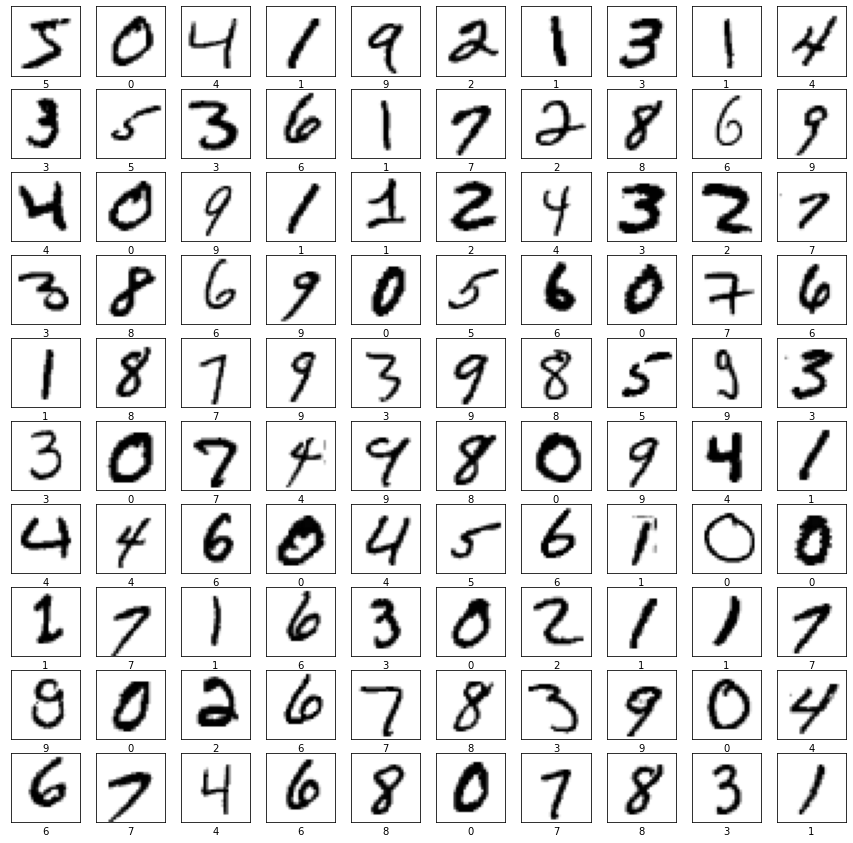

In [13]:
# 9x9 image of sample digits.
plt.figure(figsize = (15, 15))
for i in range(10*10):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

### First, flatten the images.

We need to flatten the images to use the fully connected inputs of 28 X 28 = 784 pixel features.

In [14]:
# Two different ways to use np.reshape:
x_train_flat = x_train.reshape(60000, 784)
x_test_flat = x_test.reshape(10000, -1)

print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


<hr style="border:3px solid purple"> </hr>

### Set up model

Our model will go from 784 inputs, down to a much smaller number, then back up to 784 features.

We will try to predict exactly the 784 values between 0-1 and see if we can reconstruct the input images. We'll use cross-entropy for each of the 784 pixels and treat it as a model for 784 categories.

For the activation functions, we use the sigmoid.  We *don't* want to use softmax, because that will force a probability distribution over the pixels. We want to treat this as 784 unique/separate classes.

In [15]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input

In [16]:
# The number of features in our layers will go from 784 -> 100 -> 30 -> 100 -> 784.
encoding_dim = 30
# With activations:
#    784 --(relu)--> 30 --(sigmoid)--> 784.

# Setup input layer:
input_layer = Input(shape=(784,))

# Setup encoding model:
encoded_layer = Dense(encoding_dim, activation='relu')(input_layer)

# Setup decoding model:
decoded_layer = Dense(784, activation='sigmoid')(encoded_layer)

# Chain them together using the Model api instead of the sequential api.
#    This will help us separate them out later if we want.
autoencoder = keras.Model(input_layer, decoded_layer)

# Note how we just need to create a MODEL with the input and final output.
#    The middle encoding layer is IN there because of how we defined the decoder.

In [17]:
# We can separately create an encoder and decoder if we wanted:
encoder_fun = keras.Model(input_layer, encoded_layer)

In [18]:
# Note that the MODEL usage requires an "Input()" object so to define the decoding layer:

encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder_fun = keras.Model(encoded_input, decoder_layer(encoded_input))

### What is target?

Our target is the x values. We want to minimize the difference with what we started to what we ended up with.

In [19]:
# Compile model
opt = keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(optimizer=opt, loss='binary_crossentropy', metrics=['Accuracy'])

In [20]:
model_logs = autoencoder.fit(x_train_flat, x_train_flat,
                             epochs=50,
                             batch_size=256,
                             shuffle=True,
                             validation_data=(x_test_flat, x_test_flat))

Epoch 1/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2779 - accuracy: 0.0000e+00 - val_loss: 0.1944 - val_accuracy: 0.0000e+00
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1751 - accuracy: 0.0000e+00 - val_loss: 0.1566 - val_accuracy: 0.0000e+00
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1466 - accuracy: 0.0000e+00 - val_loss: 0.1357 - val_accuracy: 0.0000e+00
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1305 - accuracy: 4.2517e-08 - val_loss: 0.1233 - val_accuracy: 0.0000e+00
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1204 - accuracy: 2.1259e-08 - val_loss: 0.1151 - val_accuracy: 1.2755e-07
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1134 - accuracy: 0.0000e+00 - val_loss: 0.1091 - val_accuracy: 0.0000e+00
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1082 - accuracy: 4.2517e

<hr style="border:3px solid purple"> </hr>

### Plot what is happening here:

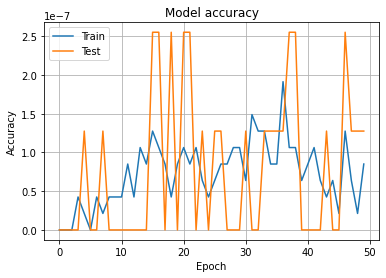

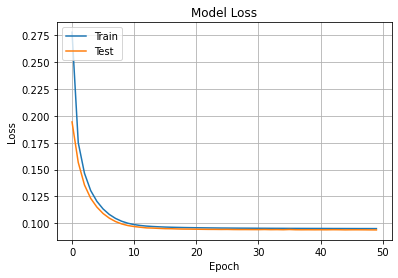

In [21]:
# Plot accuracy (Probably not that helpful here)
plt.plot(model_logs.history['accuracy'])
plt.plot(model_logs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot loss
plt.plot(model_logs.history['loss'])
plt.plot(model_logs.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

<hr style="border:3px solid purple"> </hr>

## Get predictions

Now let's see how the predictions look.

In [22]:
train_preds = autoencoder.predict(x_train_flat)
test_preds = autoencoder.predict(x_test_flat)

print(train_preds.shape)

(60000, 784)


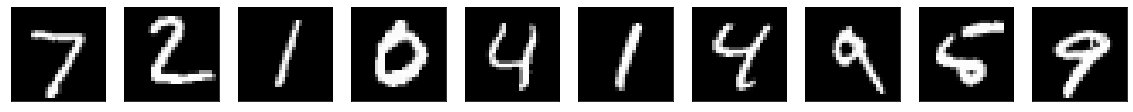

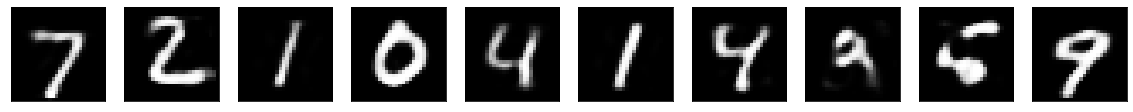

In [23]:
# Plot some outputs
num_to_plot = 10

# First plot some originals
plt.figure(figsize=(20, 4))
for i in range(num_to_plot):
    ax = plt.subplot(2, num_to_plot, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
# Second plot uncompressed predicionts
plt.figure(figsize=(20, 4))
for i in range(num_to_plot):
    ax = plt.subplot(2, num_to_plot, i + 1)
    plt.imshow(test_preds[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Smoothing!

Notice the smoothing in the images. This is due to the compression. The network learns that the exact edges and slight discrepancies between numbers are due to noise and approximates edges with smoother boundaries. This allows it to predict more general representations.

<hr style="border:3px solid purple"> </hr>

## Can we generate new numbers?

In [24]:
decoder_fun.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               24304     
Total params: 24,304
Trainable params: 24,304
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Let's input a random set of numbers

random_input = np.random.normal(size=(encoding_dim,)).reshape(-1, encoding_dim)
print(random_input.shape)
print(random_input)

(1, 30)
[[ 0.49120829 -1.45147283  0.29996853  0.01090178 -1.4000657  -1.12850403
  -0.3952688  -0.44991388  0.53563352 -2.7359183  -0.27146891  0.12252535
   1.47367623 -2.50472225  0.28624588 -0.21407478  1.08153076 -0.49637633
   0.63868156  0.73972553  1.43184389  0.53241567  0.19977072 -1.64765641
   0.85469052 -1.63469873 -1.14871009  1.83102563  2.06806041  1.21116533]]


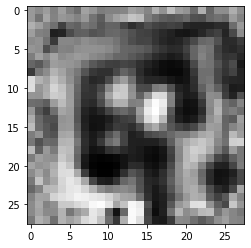

In [26]:
# Generate a digit
flat_image = decoder_fun.predict(random_input)

image_2d = flat_image.reshape(28, 28)

plt.imshow(image_2d)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### What is happening?

Probably the encoding of the digit image has a very specific distribution.

> Note: you can tell the edges are just random noise. What does this tell us about the input distribution? Why is it this way?

Instead, let's sample a random feature from the test distribution. For all 30 input encoded features.

In [27]:
# Get the output of the encoded distributions on test set:
test_encodings = encoder_fun.predict(x_test_flat)

print(test_encodings.shape)

(10000, 30)


[[ 5.451497  12.155495   9.521307   6.5054493  7.682284   9.870605
   7.386078   7.8590407  2.3441517 11.147501  13.166388   8.053108
   8.5919895  7.429007   5.557515   4.421109   1.6175865 14.044889
   7.935403   6.710195   6.8501863  2.9119518  7.1535473  6.7991996
   6.349736   5.441471   4.5527897 11.280529   4.135539   7.229688 ]]


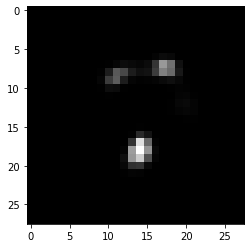

In [28]:
# Generate a digit
# Sample a random element for each of the 30 features:
# - First sample randomly for row entries.
row_ix = np.random.choice(test_encodings.shape[0], size=test_encodings.shape[1]).reshape(-1, encoding_dim)

# Select random rows in order
random_encoding_sample = np.array([test_encodings[r_ix, c_ix] for c_ix, r_ix in enumerate(row_ix)])

print(random_encoding_sample)

flat_image = decoder_fun.predict(random_encoding_sample)

image_2d = flat_image.reshape(28, 28)

plt.imshow(image_2d)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Still not quite there.

Well, probably, these 30 encoded features have a lot of dependencies on them as well.

<hr style="border:5px solid purple"> </hr>

## Convolutional Neural Networks!


Let's generate a very simple convolutional neural network on the MNIST data.


<hr style="border:5px solid purple"> </hr>

(But first, let's just do logistic regression again to arrive at a baseline.)

## Training a baseline model

Let's start by training a model using `sklearn`. As mentioned in previous notebooks, it's always good to have a **baseline** accuracy in mind, so that we can then see by how much our fancy new model can improve on that baseline, and at what cost (in terms of computation and otherwise).

To train our baseline model, we are going to use two algorithms: `LogisticRegression` because it's an efficient model and usually performs well with little need to tune it, and `MLPClassifier` which is a neural nework model in `sklearn`, so we can see what kinds of shortcomings it has compared to training a neural network model using `tensorflow` and `keras`.

### Benchmark model 1: Logistic Regression

- Train a logistic regression model and increase `max_iter` to 5000 to make sure that the model runs for enough iterations to converges. Store the predictions in `y_hat_train` and `y_hat_test`.

- 60k samples on 784 features takes a long time to converge to a solution. Here we will sample 5,000 random rows to get it to compute faster. Reason- just for class time. In a real situation, we may let this run fully to get a better solution. On my mac-laptop, the full model ran for ~15 minutes.

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Sample smaller dataset. Still takes ~ 30-45 seconds to train.
sample_size = 5000
ix_sample = np.random.choice(x_train_flat.shape[0], size=sample_size)
xs_train_flat = x_train_flat[ix_sample, :]
ys_train = y_train[ix_sample]


# Train on sample.
lr = LogisticRegressionCV(max_iter = 5000)
lr.fit(xs_train_flat, ys_train)

# Predict on full sets.
y_hat_train = lr.predict(x_train_flat)
y_hat_test = lr.predict(x_test_flat)

- Since the data is well-balanced, we can rely on accuracy to evaluate the model and make sure we're not over-fitting. Get the model's accuracy on the training and test data. We wrote some code to make it easier.

In [ ]:
acc_train = accuracy_score(y_train, y_hat_train)
acc_test = accuracy_score(y_test, y_hat_test)

print("Training data accuracy is {:2.2f}%".format(acc_train * 100))
print("Test data accuracy is {:2.2f}%".format(acc_test * 100))

<hr style="border:3px solid purple"> </hr>

### Excercise: Benchmark Model 2: Fully Connected NN

Here we will train a MLP-classifier (fully connected NN) from sklearn- `MLPClassifier()`.

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

The most important argument is has is `hidden_layer_sizes` where you specify the number of neurons in each hidden layer as a list of integers. So for example, letting `hidden_layer_sizes = [4, 3]` means that we want 2 hidden layers (size of the list) with 4 neurons in hidden layer 1 and 3 neurons in hidden layer 2. Neural networks can be very compute hungry, so we want to keep the number of layers and the number of neurons small.

- Train a neural network using `MLPClassifier`.

In [ ]:
from sklearn.neural_network import MLPClassifier

# Default is to cut it off at 200 maximum iterations. Should take ~1 minute to run.
mlp = MLPClassifier(?????, verbose=True)
mlp.fit(????)

Get the accuracy on the training and test data for the neural network. Which model performed better? The neural network or the logistic regression?

In [ ]:
y_hat_train = mlp.predict(x_train_flat)
y_hat_test = mlp.predict(x_test_flat)

acc_train = accuracy_score(y_train, y_hat_train)
acc_test = accuracy_score(y_test, y_hat_test)

print("Training data accuracy is {:2.2f}%".format(acc_train * 100))
print("Test data accuracy is {:2.2f}%".format(acc_test * 100))

So we can see from the accuracy that a logistic regression model can give neural networks a good run for your money, and in a fraction of the time. So neural networks better have something to show for it! It gets better, so keep going. With that in mind, let's now move to using `tensorflow`.

<hr style="border:3px solid purple"> </hr>

## Introduction to `tensorflow`

Before training our model let's learn a little about `tensorflow` and `keras`. The `tensorflow` library is a **low-level** library whose basic object is a **tensor**. A `tensor` object is very similar to an `array` object in `numpy`, but with some important differences that we will explain later. 

Let's look at an example. First we create two 2D `array` objects in numpy and multiply them together. Note that a 2D `array` object is what we called a marix, and so the multiplication here is **matrix multiplication**, for which we use `np.dot`.

Example:

$$
\begin{bmatrix}
1.0 & 2.0\\
3.0 & 4.0
\end{bmatrix} \cdot
\begin{bmatrix}
1.0 & 1.0\\
0.0 & 1.0
\end{bmatrix}=
\begin{bmatrix}
1.0 & 3.0\\
3.0 & 7.0
\end{bmatrix}
$$

In [ ]:
c = np.array([[1.0, 2.0], [3.0, 4.0]])
d = np.array([[1.0, 1.0], [0.0, 1.0]])
e = np.dot(c, d)
e

Here's the `tensorflow` equivalent to doing the above. We use `tf.constant` to create the tensors, and use `tf.matmult` instead of `np.dot` to do the matrix multiplication.

In [ ]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
e

There are a lot of similar functions between the two libraries. In fact, the following cell prints the names of all the functions that have the same names in `numpy` and `tensorflow`. This isn't to say that the functions behaves in exactly the same way, but most of them serve the same purpose.

In [ ]:
# Print out overlapping function in NP and TF (Ignore underscored functions)

print('\t'.join([f for f in dir(np) if f in dir(tf) and '_' not in f]))

A constant tensor like the one we created above is used to hold values that don't change, such as data. There are also tensors that can be creates as a `Variable` object: such a tensor would store values that are subject to change, such as the weights and biases of a neural network as they get updates iteration after iteration.

In [ ]:
e = tf.Variable([[1., 3.], [3., 7.]])
e

When we design a neural network at a low level, we define it by the linear algebra operations that take place for the network to go from the input data to its output: in other words the **forward pass**. We saw earlier that during **backpropagation** we traverse the network in the opposite direction and carry the gradient of the loss w.r.t. the weights and biases as we go. Of course, this meant that we needed to calculate the derivatives, which depended on the choice of the loss function itself, and on the operations we carried as we applied the chain rule. In `tensorflow` and other deep learning frameworks such as `Pytorch`, we have a concept called **auto-differentiation**, which automatically handles this for us. That means the most difficult part of creating a neural network: the backward pass, is now handled automatically! 

In addition to auto-differentiation, another big advatage of tensors are that they run on GPUs, whereas the `numpy` library only runs on CPUs. This means the same calculation can be hundreds or thousands of times faster if we use `tensorflow` instead of `numpy` (assuming we have a GPU and have `tensorflow` set up properly).

Now let's talk about `keras`. Even auto-differentiation, designing a neural network at a low-level is still a daunting task in practice, and one that most practitioners don't engage in. Instead we use the `keras` library, which is a **high-level** library that allows us to create and train a neural network from scratch in just a few lines of code and without explicitly doing our own linear algebra. For example, instead of tensors and matrix operations, `keras` has higher abstractions such as `layers`.

Convolutional Layer documentation:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

In [ ]:
keras.layers.Conv2D

Let's see `keras` in action now. Following our data exploration, we will now build our model which requires us to configure its layers, and then compile it. For this problem we will have 3 layers: a convolution layer, a hidden layer, and output layer.

By using `keras.Sequential`, we can chain a few layers to create a network, specifying a few arguments along the way:

- The first layer `tf.keras.layers.Conv2D` applies a 2D convolutional filter(s) along image. We have to specify shape, stride, # features, and how to deal with the edges. 
- The next layer `tf.keras.layers.Dense` is a **densely-connected**, or **fully-connected** layers with 128 nodes (or neurons) and a **ReLU** activation function.
- The next layer `tf.keras.layers.Dense` is anther dense layer with 10 nodes. Since this is the last layer, it is the **output layer**. This explains why it has 10 nodes: we're training a model that is distinguishing between the digits 0-9. We apply a `softmax` activation function to it. This is because softmax takes the output of the last layer and turns it into probabilities.

<hr style="border:3px solid purple"> </hr>


## Continue w/ Convolutional NN


### Issue with input image data shape.

Tensorflow/Keras assumes that you have 3D- images (Height, Width, Channels). MNIST is only 1 channel and doesn't specify that dimension, i.e., the images are 28x28.

To specify that the images are 28x28x1, we need to add a "Dummy" Dimension.  This is essentially:

```
image_before = [[pixel row 1], [pixel row 2], ...]

image_after = [[[pixel row 1], [pixel row 2], ...]]

```

Where the shapes are :

- image_before.shape -> (h, w)
- image_after.shape -> (h, w, 1)

In [ ]:
# Example:
t1 = np.array([[1, 2], [3, 4], [5, 6]])
print(t1.shape)

t2 = np.array([t1])
print(t2.shape)

In [ ]:
# Implemented:
xc_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
xc_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print(xc_train.shape)
print(xc_test.shape)

In [ ]:
# Remember that we have 10 outputs for 10 different classes/integers
model = keras.Sequential([
    keras.layers.Conv2D(filters=64,
                        kernel_size=(8, 8),
                        strides=2,
                        padding='same',
                        input_shape=(28,28,1),
                        activation='relu',
                        data_format='channels_last'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

### NOTE:

Notice the shape and dimensions of our models. We need an internal "flatten" command once we get to a small enough convolutional filter shape/features. Here we didn't try really at all and are still left with 12,544 outputs.

What does flatten do?
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

Concatenates each image into a flat array. The documentation specifies the default order. We can also specify other orderings.

Connecting the 12,544 outputs to a 128 node fully connected layer results in (12544)x(128) + 128 = 1,605,760 parameters.

### Compiling Model

Before we train our model, we need to compile it by defining our optimizer, loss function, and the metric used to monitor the training steps.

In [ ]:
# Specify Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# Specify sparse categorical cross entropy
scce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model.compile(optimizer = opt, 
              loss = scce_loss,
              metrics = ['accuracy'])

After compiling our model, we train the model the same way we do in `sklearn`: we call `fit` and pass the training data and the labels. In `keras` we also need to specify the number of epochs we wish to train.

In [ ]:
model_logs = model.fit(xc_train, y_train.reshape(-1),
                       epochs=5,
                       batch_size=64,
                       validation_data=(xc_test, y_test))

You notice that for each epoch, the model prints out the accuracy while it trains. After done training, we will now evaluate our model on the test set. Calling evaluate is a shortcut: it first calls `model.predict` to get predictions for the test data, and then obtains the loss on the test data. Since we specified `sparse_categorical_crossentropy` as the loss function to use when we compiled the model, we don't need to specify that here again. Additionally, during training and testing, we are also presented with the accuracy.

<hr style="border:3px solid purple"> </hr>

### Evaluating our model!

In [ ]:
test_loss, test_acc = model.evaluate(xc_test, y_test)

print('Test accuracy:', test_acc)

> Note! the evaluation step- it took 2ms/step (step = 64 images), so it's evaluating at 2/64 ms per image. This is about 35,000 images evaluated per second!

In [ ]:
print([k for k in model_logs.history.keys()])

In [ ]:
plt.plot(model_logs.history['accuracy'], label='Training Acc')
plt.plot(model_logs.history['val_accuracy'], label='Training Acc')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

We notice that the accuracy of our training set is higher than that of the test set. This is an example of over-fitting.

Now, let us take a look at what a neural network predicts.

In [ ]:
test_preds = model.predict(xc_test)
print(test_preds.shape)
print(test_preds[:3,:])

In [ ]:
# Calculate actual class predicted.
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels.shape)
print(pred_labels[:10])

In [ ]:
# Plot some predictions

plt.figure(figsize = (15, 15))
for i in range(10*10):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(xc_test[i]), cmap = plt.cm.binary)
    plt.xlabel("{} {:2.0f}% ({})".format(np.argmax(test_preds[i]), 100 * np.max(test_preds), y_test[i]))
plt.show()

<hr style="border:3px solid purple"> </hr>

### Inspect the ones we missed

It's probably more helpful to see which images we missed. Let's do the same plot with the images we got wrong.

In [ ]:
# How many did we miss?
wrong_ix = [ix for ix, (p, a) in enumerate(zip(pred_labels, y_test)) if p!=a]
missed_count = len(wrong_ix)
print('We missed {:,} digits in the test set.'.format(missed_count))

In [ ]:
# Plot them
plt.figure(figsize = (15, 15))
for ix, i in enumerate(wrong_ix[:100]):
    plt.subplot(10, 10, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(xc_test[i]), cmap = plt.cm.binary)
    plt.xlabel("{} {:2.0f}% ({})".format(np.argmax(test_preds[i]), 100 * np.max(test_preds), y_test[i]))
plt.show()

<hr style="border:5px solid purple"> </hr>

# Applying AlexNet on CIFAR10

Let's build Alexnet on CIFAR10 and see how it performs.

CIFAR 10:

CIFAR 10 docs: https://www.cs.toronto.edu/~kriz/cifar.html

10 labels:

- Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

There is also a CIFAR 100 if you are interested.

### AlexNet:

https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

2012 ILSVRC Competition winner.

### First, load the data.
(Can take a few minutes.)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Conv3D,MaxPool2D
from tensorflow.keras.optimizers import SGD
import datetime, os

# Setup Tensorboard for monitoring
%load_ext tensorboard

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [ ]:
print(train_images.shape)
# Notice train-labels shape is 2 dimensional.
print(train_labels.shape)
# Print red channel layer (top left corner) of first image. Notice these are integers between 0 and 255.
print(train_images[0, :5, :5, 1])
print(train_labels[0])

In [ ]:
# Setup class names
class_names= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Separate validation sets from train sets
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

### Let's just look at the first few images

In [ ]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(zip(train_images[:5,:,:,:], train_labels[:5,:])):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(class_names[label[0]])
    plt.axis('off')

### Standardize all images

Image data for NNs should be standardized

In [ ]:
train_images = train_images / 255.0
validation_images = validation_images / 255.0
test_images = test_images / 255.0

### Setup AlexNet

In [ ]:
model = Sequential()

# Layer 1: 3x3 convolution w/ stride 1, & 48 features.
model.add(Conv2D(48,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding='same', 
                 input_shape=train_images.shape[1:]))
# Followed by Max Pooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#Layer 2: 3x3 convolution w/ stride 1, & 96 features.
model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same'))
# Followed by Max Pooling
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


#Layer 3: 3x3 convolution w/ stride 1, & 192 features.
model.add(Conv2D(192,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same') )
# Followed by Max Pooling
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Layer 4: 3x3 convolution w/ stride 1, & 192 features.
model.add(Conv2D(192,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same'))
# Followed by Max Pooling
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Layer 5: 3x3 convolution w/ stride 1, & 256 features.
model.add(Conv2D(256,
                 kernel_size=(3,3),
                 activation='relu',
                 padding='same'))
# Followed by Max Pooling
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flatten
model.add(Flatten())

#Layer 6: Dense layer to 512 neurons.
model.add(Dense(512, activation='tanh'))

#Layer 7 : Dense layer to 256 neurons.
model.add(Dense(256, activation='tanh'))

#Prediction: Dense layer to 10 neurons.
model.add(Dense(10, activation='softmax'))

model.summary()

### Setup Model learning parameters



In [ ]:
epochs = 10
batch_size = 64
learningRate = 0.02

### Setup directories and callbacks for Tensorboard

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

### Add confusion matrix to Tensorboard:

Adapted from:
- https://stackoverflow.com/questions/41617463/tensorflow-confusion-matrix-in-tensorboard

In [ ]:
import itertools
import pandas as pd
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [ ]:
import io

def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [ ]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_images)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [ ]:
confusion_matrix_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

### Compile model

In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=SGD(lr=learningRate),
              metrics=['accuracy'])

### Start Tensorboard

```
%tensorboard --logdir logs
```

The above command is needed before we start training. We are telling it where the new logs are going to be. Otherwise Tensorboard will start where it left off, and we ran it last class so you'll just see the prior networks.

Note that the first call back ONLY occurs after an epoch has finished. You'll have to wait for that before seeing data in tensorboard.

AFTER we start the training, then you can navigate to:

http://0.0.0.0:6006/

In [ ]:
# You may need to 'kill' a background process to start.
# If the port is still used, try: BASH command:
#$ lsof -i:6006
# Then write with the PID: (say PID=31501)
# !kill 31501

In [ ]:
%tensorboard --logdir logs --port 6006

In [ ]:
model_logs = model.fit(train_images, train_labels,
                       epochs=epochs,
                       batch_size= batch_size,
                       validation_data=(validation_images, validation_labels),
                       callbacks=[tensorboard_callback, confusion_matrix_callback])

### Evaluate model

We only trained for 10 iterations. Probably should train much longer.

In [ ]:
from sklearn.metrics import accuracy_score
print('Predicting Train Set')
train_prob = model.predict(train_images)
train_pred = np.argmax(train_prob, axis=1)
train_acc = accuracy_score(train_pred, train_labels.squeeze())
print('Train Acc: {:.4f}'.format(train_acc))

print('Predicting Validation Set')
validation_prob = model.predict(validation_images)
validation_pred = np.argmax(validation_prob, axis=1)
validation_acc = accuracy_score(validation_pred, validation_labels.squeeze())
print('Validation Acc: {:.4f}'.format(validation_acc))

print('Predicting Test Set')
test_prob = model.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_acc = accuracy_score(test_pred, test_labels.squeeze())
print('Test Acc: {:.4f}'.format(test_acc))

In [ ]:
# Plot some predictions
plt.figure(figsize = (15, 15))
for i in range(10*10):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(test_images[i]))
    plt.xlabel("p-{}, a-{}".format(class_names[test_pred[i]], class_names[test_labels[i][0]]))
plt.show()

In [ ]:
# Confusion matrix for test set
conf_mat_data = confusion_matrix(test_pred, test_labels)

conf_df = pd.DataFrame(conf_mat_data, columns=class_names, index=class_names)
conf_df